In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [151]:
torch.manual_seed(7)

In [152]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=64, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_34880/2182951934.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_34880/2182951934.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [153]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=64, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_34880/2331197148.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_34880/2331197148.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [154]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    diff = (torch.sum(torch.abs(inl.weight.data - ninc)).item(), torch.sum(torch.abs(oul.weight.data-noul)).item())

    inl.weight.data = ninc
    oul.weight.data = noul

    return diff


In [155]:
# lay = []
# norm = True
# for n, i in model.named_children():
#     print(type(i).__name__)
#     if type(i).__name__ == "Linear":
#         lay.append((n, i))

# norms = {}

# num_epochs = 20  
# for epoch in range(num_epochs):
#     for b in tqdm(trainloader):
#         xt, y = b[0], b[1]
#         optimizer.zero_grad() 
#         outputs = model(xt)  
#         loss = criterion(outputs, y) 
        
#         loss.backward() 
#         optimizer.step() 
    
#     # diffs = {}

#     if epoch == 0:
#         for i in range(len(lay)):
#             # diffs[i] = torch.sum(lay[i][1].weight.data).item()
#             norms[i] = torch.linalg.norm(lay[i][1].weight.data)
    
#     # while any(val >= 1 for val in diffs.values()):
#     for i in range(len(lay)):
#         if i > 0 and i <= len(lay)-1:
#             di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
#             while(di[0]+di[1] > .001):
#                 di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])    
#             # diffs[i] = torch.sum(lay[i][1].weight.data - diffs[i]).item()

#     if norm:
#         for i in range(len(lay)):
#             lay[i][1].weight.data = (lay[i][1].weight.data/torch.linalg.norm(lay[i][1].weight.data))*norms[i]


#     print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

#     for i in range(len(lay)):
#         print(f'layer l2 norm for layer {i} = {torch.linalg.norm(lay[i][1].weight, ord=2)}')
        
#     tot = 0
#     corr = 0

#     with torch.no_grad():
#         for i in testloader:
#             xt, y = i[0], i[1]
#             outputs = model(xt)  
#             _, y = torch.max(y.data, 1)
#             _, pred = torch.max(outputs.data, 1)
#             tot += y.shape[0]
#             corr += (pred == y).sum().item()
#     print(f'test dataset accuracy: {100*corr/tot}%')

# ------------------------------------------------------------------------------------------------------------------------

lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

norms = {}

num_epochs = 20  
for epoch in range(num_epochs):
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
    # diffs = {}

    if epoch == 0:
        for i in range(len(lay)):
            # diffs[i] = torch.sum(lay[i][1].weight.data).item()
            norms[i] = torch.linalg.norm(lay[i][1].weight.data)

    print(norms.values())
    
    # while any(val >= 1 for val in diffs.values()):
    while(max(norms.values()) - min(norms.values()) > 2):
        for i in range(len(lay)):
            if i > 0 and i <= len(lay)-1:
                di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
            norms[i] = torch.linalg.norm(lay[i][1].weight, ord=2)

            # diffs[i] = torch.sum(lay[i][1].weight.data - diffs[i]).item()

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    for i in range(len(lay)):
        print(f'layer l2 norm for layer {i} = {torch.linalg.norm(lay[i][1].weight, ord=2)}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')


Linear
Linear
Linear
Linear
Linear
Linear


100%|██████████| 938/938 [00:02<00:00, 431.57it/s]


dict_values([tensor(55.5481), tensor(29.7507), tensor(22.7216), tensor(9.7366), tensor(6.2932), tensor(2.6916)])
Epoch 0/20, Loss: 0.011904964223504066
layer l2 norm for layer 0 = 7.366003036499023
layer l2 norm for layer 1 = 6.676914691925049
layer l2 norm for layer 2 = 6.543136119842529
layer l2 norm for layer 3 = 6.647246360778809
layer l2 norm for layer 4 = 6.201691150665283
layer l2 norm for layer 5 = 5.945400238037109
test dataset accuracy: 60.62%


100%|██████████| 938/938 [00:02<00:00, 465.85it/s]


dict_values([tensor(7.5802, grad_fn=<AmaxBackward0>), tensor(6.9702, grad_fn=<AmaxBackward0>), tensor(6.8306, grad_fn=<AmaxBackward0>), tensor(6.8651, grad_fn=<AmaxBackward0>), tensor(6.3025, grad_fn=<AmaxBackward0>), tensor(5.9454, grad_fn=<AmaxBackward0>)])
Epoch 1/20, Loss: 0.09056886285543442
layer l2 norm for layer 0 = 13.050583839416504
layer l2 norm for layer 1 = 8.19398021697998
layer l2 norm for layer 2 = 9.124343872070312
layer l2 norm for layer 3 = 6.844848155975342
layer l2 norm for layer 4 = 7.813380241394043
layer l2 norm for layer 5 = 5.953701496124268
test dataset accuracy: 10.28%


100%|██████████| 938/938 [00:01<00:00, 476.66it/s]


dict_values([tensor(7.5802, grad_fn=<AmaxBackward0>), tensor(6.9702, grad_fn=<AmaxBackward0>), tensor(6.8306, grad_fn=<AmaxBackward0>), tensor(6.8651, grad_fn=<AmaxBackward0>), tensor(6.3025, grad_fn=<AmaxBackward0>), tensor(5.9454, grad_fn=<AmaxBackward0>)])
Epoch 2/20, Loss: 0.09041526913642883
layer l2 norm for layer 0 = 13.050583839416504
layer l2 norm for layer 1 = 8.19398021697998
layer l2 norm for layer 2 = 9.124343872070312
layer l2 norm for layer 3 = 6.844848155975342
layer l2 norm for layer 4 = 7.813380241394043
layer l2 norm for layer 5 = 5.953701496124268
test dataset accuracy: 11.35%


100%|██████████| 938/938 [00:02<00:00, 462.10it/s]


dict_values([tensor(7.5802, grad_fn=<AmaxBackward0>), tensor(6.9702, grad_fn=<AmaxBackward0>), tensor(6.8306, grad_fn=<AmaxBackward0>), tensor(6.8651, grad_fn=<AmaxBackward0>), tensor(6.3025, grad_fn=<AmaxBackward0>), tensor(5.9454, grad_fn=<AmaxBackward0>)])
Epoch 3/20, Loss: 0.09036920964717865
layer l2 norm for layer 0 = 13.050583839416504
layer l2 norm for layer 1 = 8.19398021697998
layer l2 norm for layer 2 = 9.124343872070312
layer l2 norm for layer 3 = 6.844848155975342
layer l2 norm for layer 4 = 7.813380241394043
layer l2 norm for layer 5 = 5.953701496124268
test dataset accuracy: 11.35%


100%|██████████| 938/938 [00:01<00:00, 484.99it/s]


dict_values([tensor(7.5802, grad_fn=<AmaxBackward0>), tensor(6.9702, grad_fn=<AmaxBackward0>), tensor(6.8306, grad_fn=<AmaxBackward0>), tensor(6.8651, grad_fn=<AmaxBackward0>), tensor(6.3025, grad_fn=<AmaxBackward0>), tensor(5.9454, grad_fn=<AmaxBackward0>)])
Epoch 4/20, Loss: 0.08958762139081955
layer l2 norm for layer 0 = 13.050583839416504
layer l2 norm for layer 1 = 8.19398021697998
layer l2 norm for layer 2 = 9.124343872070312
layer l2 norm for layer 3 = 6.844848155975342
layer l2 norm for layer 4 = 7.813380241394043
layer l2 norm for layer 5 = 5.953701496124268
test dataset accuracy: 10.1%


 70%|███████   | 657/938 [00:01<00:00, 474.09it/s]


KeyboardInterrupt: 

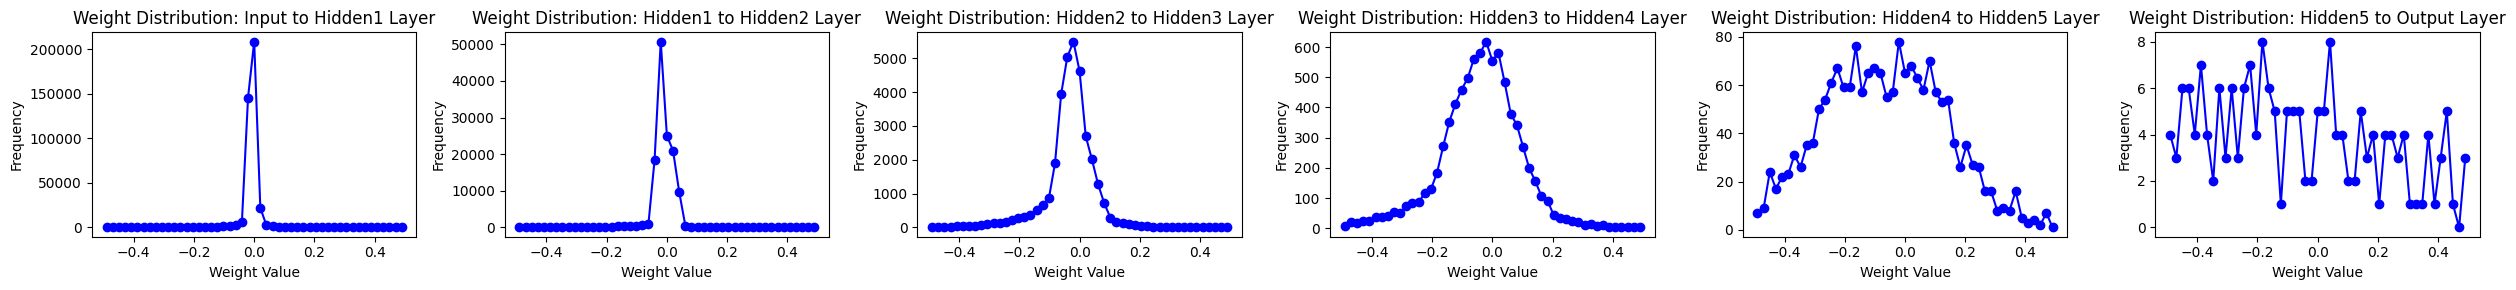

In [ ]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
fc3_weights = model.fc3.weight.cpu().detach().numpy().flatten()
fc4_weights = model.fc4.weight.cpu().detach().numpy().flatten()
fc5_weights = model.fc5.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
fc3_hist, fc3_bins = np.histogram(fc3_weights, bins=bins)
fc4_hist, fc4_bins = np.histogram(fc4_weights, bins=bins)
fc5_hist, fc5_bins = np.histogram(fc5_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
fc3_bin_centers = 0.5 * (fc3_bins[:-1] + fc3_bins[1:])
fc4_bin_centers = 0.5 * (fc4_bins[:-1] + fc4_bins[1:])
fc5_bin_centers = 0.5 * (fc5_bins[:-1] + fc5_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 3))

plt.subplot(1, 6, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden1 to Hidden2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 3)
plt.plot(fc3_bin_centers, fc3_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden2 to Hidden3 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 4)
plt.plot(fc4_bin_centers, fc4_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden3 to Hidden4 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 5)
plt.plot(fc5_bin_centers, fc5_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden4 to Hidden5 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 6)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden5 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.1):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.fc3, threshold=threshold_value)
nonzero_fc4 = count_nonzero_weights_above_threshold(model.fc4, threshold=threshold_value)
nonzero_fc5 = count_nonzero_weights_above_threshold(model.fc5, threshold=threshold_value)
nonzero_out = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1} = {100*nonzero_fc1/(model.fc.weight.data.shape[0]*model.fc.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2} = {100*nonzero_fc2/(model.fc2.weight.data.shape[0]*model.fc2.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3} = {100*nonzero_fc3/(model.fc3.weight.data.shape[0]*model.fc3.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc4} = {100*nonzero_fc4/(model.fc4.weight.data.shape[0]*model.fc4.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc5} = {100*nonzero_fc5/(model.fc5.weight.data.shape[0]*model.fc5.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_out} = {100*nonzero_out/(model.out.weight.data.shape[0]*model.out.weight.data.shape[1])}%')

Number of non-zero weights greater than 0.01 in layer 1: 197061 = 49.09244459502551%
Number of non-zero weights greater than 0.01 in layer 1: 106808 = 81.488037109375%
Number of non-zero weights greater than 0.01 in layer 3: 28242 = 86.187744140625%
Number of non-zero weights greater than 0.01 in layer 1: 7644 = 93.310546875%
Number of non-zero weights greater than 0.01 in layer 1: 1985 = 96.923828125%
Number of non-zero weights greater than 0.01 in layer 1: 315 = 98.4375%


In [ ]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.541113884549885, 0.4846061544781701, 0.9820256851346721, 0.9820256233981235, 0.9820255227088097, 0.982025567452046, 0.9820255176239492, 0.5545993009820677, 0.9820256009303342, 0.9820255469545315, 0.982025612345196, 0.9820255785599925, 0.982025476950314, 0.9820256430855916, 0.9820255486688706, 0.9820255807961362, 0.9820256290679199, 0.9820255763105185, 0.9820254895798954, 0.9820256247821955, 0.982025646553135, 0.9820254134380517, 0.9820256067485774, 0.9820255625395307, 0.982025537821253, 0.9820256514141774, 0.9820255691916876, 0.9820257074128823, 0.9820255674288495, 0.982025593456367, 0.9820255540140573, 0.9820255611027454, 0.9820254638842822, 0.982025614209065, 0.4007632733928503, 0.9820255781798582, 0.9820255627756855, 0.9820255360668939, 0.9820254587263848, 0.5604467705887095, 0.9706336047577556, 0.9820256469601402, 0.9820255280951424, 0.9820256156956726, 0.9820256061546979, 0.5823937692748676, 0.9820256180317665, 0.9820254867196, 0.9820255289534733, 0.9820256348766301, 0.98202552